In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import sys
import os
sys.path.append(os.pardir)

In [49]:
from create_hdf_dataset import create_bird_spectrogram_hdf, create_hdfs, create_bird_spectrogram_hdf_external

In [50]:
from glob import glob

In [23]:
import h5py
import numpy as np

# define path to wav files and output path for hdf files

using bird data from tchernichovski and jarvis 2021

In [135]:
path2wavs = '/home/gagan/data/tchernichovski_jarvis_2021/'

out_path = '/home/gagan/data/zudeep/bird_hdfs/'

In [182]:
birds = glob(path2wavs + 'Box*')
birdnames = [b.split('/')[-1] for b in birds]
print('.... %d birds found ....'%(len(birdnames)))

.... 230 birds found ....


In [137]:
birdnames[0]

'Box5_HP24'

# create individual bird hdfs

Tchernichovski, Jarvis 2021 birds

In [ ]:
for i in range(len(birdnames)):
    if not os.path.exists(os.path.join(out_path, birdnames[i])):
        create_bird_spectrogram_hdf_external(birdnames[i], birds[i], out_path, target_sampling_rate=16000, standardize=False, nfft=256,
                                         min_syll_dur_frames=20, energy_thresh_percent=0.1, compress_type='gzip', compression_idx=9)

Our birdsongs

In [9]:
path2wavs = '/home/gagan/data/zudeep/wav_files/'

In [17]:
create_hdfs(path2wavs, out_path, extention='SAP_allfiles', extention2 = 'songs', 
                downsample_factor = 2, nfft = 256)


 ..... bird is b14r16_tutor ....


 ..... bird is k6r16_tutor ....


 ..... bird is b9r14 ....


 ..... bird is b13r14 ....


 ..... bird is r15y5_tutor ....

..... bird r15y5_tutor finished in 20.28 secs.....

 ..... bird is r15y2_tutor ....

..... bird r15y2_tutor finished in 19.77 secs.....

 ..... bird is g20r15_tutor ....

..... bird g20r15_tutor finished in 9.06 secs.....


# explore one birds file

 load one hdf file

In [215]:
bird = 'r15y5_tutor'

In [238]:
birdfile = h5py.File(os.path.join(out_path, bird),'r')

list some data folders for this bird

In [220]:
list(birdfile['/'].keys())

['tutor']

list some wav files for one folder

In [221]:
list(birdfile['/tutor'].keys())[-5:]

['r15y5U-f00597-2.wav_100',
 'r15y5U-f00598-1.wav_100',
 'r15y5U-f00600-1.wav_100',
 'r15y5U-f00601-1.wav_100',
 'r15y5U-f00614-1.wav_100']

In [237]:
birdfile.close()

In [ ]:
names = []
with h5py.File(os.path.join(out_path, bird), 'r') as hf:
    aa = hf.visit(print)
    names.append(aa)

In [239]:
names = get_dataset_keys(birdfile)

# plot a spectrogram

In [29]:
import matplotlib.pyplot as plt
from utils.utils import transform, rescale_spectrogram

In [287]:
S = np.array(birdfile['idx_1000112_Box4_LB5_UD_LB5_43535.42576086_3_11_11_49_36.wav_42'])
S.shape

(129, 71, 2)

In [288]:
S = transform(S)

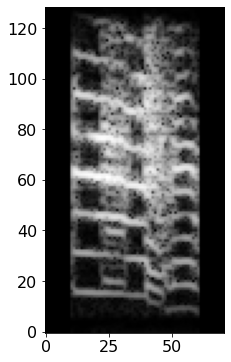

In [289]:
plt.figure(figsize = (15,6))
plt.imshow(rescale_spectrogram(S), cmap = 'gray', origin='lower')
plt.show()

# make single hdf file

In [250]:
def make_single_hdf(path2hdfs, save_dir):
    """Go through each hdf file 
    """
    # make sure all files in this folder are hdfs
    bird_hdfs = os.listdir(path2hdfs)
    idx = 0
    with h5py.File(save_dir, 'w') as file:
        
        for b in bird_hdfs:
            
            birdfile = h5py.File(os.path.join(path2hdfs,b), 'r')
            # get file names
            fnames = get_dataset_keys(birdfile)
            # go through file names, get spectrograms and put them in new file
            for f in fnames:
                data = np.array(birdfile[f])
                # replace all / with _
                fn = f.replace('/','_')
                file.create_dataset('idx_'+str(idx)+'_'+fn, data=data, 
                                 compression = 'gzip', compression_opts = 5)
                idx += 1
            birdfile.close()
            print('..... done with bird %s, count = %d .....'%(b, idx))
            
    return idx

In [ ]:
make_single_hdf('/home/gagan/data/zudeep/bird_hdfs/', '/home/gagan/data/zudeep/all_birds.hdf')

load the single birds file, divide indices into train and test

In [252]:
birdfile = h5py.File('/home/gagan/data/zudeep/all_birds.hdf','r')

In [263]:
id_list_train, id_list_test = make_single_file_id_lists(birdfile)

In [276]:
len(id_list_train)

1150493

In [285]:
id_list_train[101]

{'id': 125,
 'birdname': 'Box4',
 'within_file': 'idx_1000112_Box4_LB5_UD_LB5_43535.42576086_3_11_11_49_36.wav_42',
 'age_weight': nan}

In [267]:
import pickle

In [268]:
with open('/home/gagan/data/zudeep/id_list_train_single_file.pkl','wb') as f:
    pickle.dump(id_list_train, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/gagan/data/zudeep/id_list_test_single_file.pkl','wb') as f:
    pickle.dump(id_list_test, f, protocol=pickle.HIGHEST_PROTOCOL)

In [262]:
def make_single_file_id_lists(birdfile, train_size=0.8):
    """Makes id lists for train and test when all data is within one 
        HDF file.
    """
    all_wav_names = list(birdfile.keys())
    N = len(all_wav_names)
    idx_train = np.random.choice(N, size = int(train_size*N), replace=False)
    id_list_train = []
    id_list_test = []
    
    for i, f in enumerate(all_wav_names):
        if i in idx_train:
            birdname = f.split('_')[2]
            id_list_train.append({'id':i, 'birdname': birdname,
                                'within_file': f, 'age_weight': np.nan,
                                 })
        else:
            id_list_test.append({'id':i, 'birdname': birdname,
                                'within_file': f, 'age_weight': np.nan,
                                 })
            
    return id_list_train, id_list_test

# make id lists

ID lists are used by the songbird_dataset class to select random spectrograms during training

In [5]:
out_path

'/media/songbird/datapartition/mdgan_training_input_with_age_HDF/'

In [7]:
id_list, age_weight_list, cnt = make_ID_list(out_path)

..... 0 of 14 birds indexed .....
..... 1 of 14 birds indexed .....
..... 2 of 14 birds indexed .....
..... 3 of 14 birds indexed .....
..... 4 of 14 birds indexed .....
..... 5 of 14 birds indexed .....
..... 6 of 14 birds indexed .....
..... 7 of 14 birds indexed .....
..... 8 of 14 birds indexed .....
..... 9 of 14 birds indexed .....
..... 10 of 14 birds indexed .....
..... 11 of 14 birds indexed .....
..... 12 of 14 birds indexed .....
..... 13 of 14 birds indexed .....


# split id lists into test and train

In [8]:
id_list_train, id_list_test = split_ids_train_test(id_list, train_test_ratio = 0.9)

# save id and age weight lists with pickle (only use pickle!)

In [11]:
import pickle

In [13]:
with open('/media/songbird/datapartition/id_list_train.pkl','wb') as f:
    pickle.dump(id_list_train, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/media/songbird/datapartition/id_list_test.pkl','wb') as f:
    pickle.dump(id_list_test, f, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
age_weights_train = [ids['age_weight'] for ids in id_list_train]
age_weights_test = [ids['age_weight'] for ids in id_list_test]

In [15]:
with open('/media/songbird/datapartition/age_weights_training.pkl', 'wb') as f: 
    pickle.dump(age_weights_train, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('/media/songbird/datapartition/age_weights_test.pkl', 'wb') as f: 
    pickle.dump(age_weights_test, f, protocol=pickle.HIGHEST_PROTOCOL)